# Análisis comparativo y predictivo de los incidentes viales en la CDMX con machine learning

**Lenguaje de programación:** Python

**Equipo:** 5

**Integrantes:**

* Ximena Ávila Villagómez

* Félix Alberto Nieto García

* Alejandro De Fuentes Martínez

# Índice de contenido

0. Librerías

  0.1 Instalación de librerías

  0.2 Librerías utilizadas

1. Identificación del problema
2. Plantemiento de preguntas
3. Funciones

  3.1 Adquisición de datos mediante API y su tranformación

  3.2 Graficación

  3.3 Procesado

4. Colección de datos
  
  4.1 Incidentes víales C5

  4.2 Demarcación territorial de la CDMX

  4.3 Vías principales de la CDMX 

5. Análisis Multivariable para el análisis comparativo

6. Principales hallazgos del método heurístico

  6.1 Localización de los puntos con alta densidad de incidentes
  
  6.2 Clasificación de los puntos de alta incidencia con K-Means
  
  6.3 Avenidas principales de alto índice de incidentes 

  6.4. Estudio de los accidentes de cada vía principal

  6.5. Mapa con capas interactivas de los resultados

7. Técnicas de Machine Learning para el análisis predictivo

  7.1. Predicciones con Random Forest

  7.2. Predicciones sobre las Series de Tiempo

8. Planes a futuro

9. Conclusiones


## 0. Librerias

### 0.1 Instalación de librerias 

In [ ]:
!pip install statsmodels --upgrade

In [ ]:
!pip install geojson;
!pip install geopandas;
!pip install pygeos
!pip install fiona shapely pyproj rtree

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 0.2 Librerias utilizadas

In [ ]:
#Manejo, tranformación y adquisición de datos
import pandas as pd 
import numpy as np  
import json #Manejo de archivos json
import requests #Para hacer solicitudes HTTP
import geojson
import geopandas as gpd
from shapely.geometry import Point, Polygon,LineString, MultiLineString, MultiPoint

/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.0-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [ ]:
#Graficación
import seaborn as sns  
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import folium  # Visualización de datos en mapas interactivos
import folium.plugins #Herramientas para mapas interactivos
import branca.colormap as cm

In [ ]:
#Calculos estadisticos y clasificación
from scipy import stats #1
from scipy.stats import skew, kurtosis #2
from sklearn.cluster import KMeans
from scipy.spatial import Voronoi, voronoi_plot_2d

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
#Para las prediciones
from matplotlib import pyplot
#from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

#Para el modelo ARIMA
from pandas import datetime
import pandas.util.testing as tm
#from statsmodels.tsa.arima.model import ARIMA

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  if sys.path[0] == '':


In [ ]:
from sklearn.metrics import silhouette_score
import sklearn.cluster as cluster

## 1. Identificación del problema

Los accidentes de tránsito son una de las principales causas de muerte a nivel nacional e incluso a nivel mundial, representan un problema de seguridad vial que requiere de un análisis cuidadoso así como de estudios continuos para buscar soluciones que disminuyan su frecuencia.

Durante las fases pasadas se exploró el problema por medio del procesamiento de datos sobre los accidentes viales en la CDMX registrados por el C5 desde 2014 hasta  principios de 2021. En la misma investigación se utilizaron datos sobre la ubicación de vías principales, de trásito de autobuses, estaciones, etc. Se observaron algunos hechos relevantes como los meses en los que ocurren más incidentes, los días y el tipo de accidente más frecuente por localización, las alcaldías con más accidentes dependiendo el tipo y posibles coincidencias con la concurrencia de las avenidas y la cantidad de accidentes. De esta forma, el problema se ha analizado y descrito detalladamente en entregas anteriores.

En este último módulo se explorarán las posibles predicciones de comportamientos para determinados tipos de incidentes viales, con el uso de Machine Learning. También se aplicarán algoritmos de clusterización a fin de explicar clasificaciones o agrupaciones de incidentes viales en función de variables identificadas. Esto brindaría información útil basada en evidencias de los datos para plantear estrategias de prevención así como sugerir perspectivas más amplias del problema.


## 2 Planteamiento de preguntas

**Preguntas iniciales sugeridas para el proyecto**
*   ¿Cómo se clasifican y se ven expresados en clústers con K-Means los distintos tipos de accidentes para las 16 alcaldías de las CDMX?
*   ¿Qué cantidad de accidentes pueden predecirse de un cierto tipo para una alcaldía en particular en un año próximo? Ejemplo -->
*   ¿Cómo el aumento de la cantidad de datos puede modificar la precisión, sensibilidad y especificidad del modelo planteado?

## 3. Funciones 

### 3.1 Adquisición de datos mediante API y su tranformación

In [ ]:
#Función para adquirir datos mediante API
def get_data_API(link):
  r = requests.get(link)
  r.status_code
  consulta = r.json()
  D = pd.json_normalize(consulta['result']['records'])
  r.close()
  df = pd.DataFrame.from_dict(D)
  return df

In [ ]:
def clean_data(df):
  col = df.columns
  if 'geometry' in col:
    geoname = 'geometry'
  elif 'geo_shape' in col:
    geoname = 'geo_shape'
  else:
    geoname = 'no'

  if 'geo_point_2d' in col:
    geopoint = 'geo_point_2d'
  elif "geopoint" in col:
    geopoint = 'geopoint'
  else:
    geopoint = 'no'


  if geoname != 'no':
    df['geometry'] = df[geoname].apply(lambda x: json.loads(x))

  if geopoint != 'no':
    df[['latitud','longitud']] = df[geopoint].str.split(',',expand=True).astype(float)

  borrar =  ['geo_shape','id','_id']
  b = []
  for i in borrar:
    if i in col:
      b.append(i)
  if geopoint != 'no':
    b.append(geopoint)
  
  df = df.drop(columns=b)

  return df

In [ ]:
def transform_geometry(diccionario):
  if diccionario['type'] == 'Polygon':
    return Polygon(diccionario['coordinates'][0])
  elif diccionario['type'] == 'LineString':
    return LineString(diccionario['coordinates'])
  elif diccionario['type'] == 'Point':
    return Point(diccionario['coordinates'])
  elif diccionario['type'] == 'MultiLineString':
      return MultiLineString(diccionario['coordinates'])

def set_geometry(df,columna):
  df[columna] = df[columna].apply(lambda x:transform_geometry(x))
  return gpd.GeoDataFrame(df,crs='EPSG:4326')

def transform_data(df):
  col = df.columns
  if ('geometry' in col) :
    df = set_geometry(df, columna='geometry')
  elif ('latitud' in col) and ('longitud' in col):
    df = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['longitud'], df['latitud']),crs='EPSG:4326')
  
  elif 'WKT' in col:
    df['geometry'] = gpd.GeoSeries.from_wkt(df['WKT'])
    df = gpd.GeoDataFrame(df,geometry='geometry',crs='EPSG:4326')
    df = df.drop(columns=['WKT']) 

  return df

### 3.2 Graficación

In [ ]:
def add_data(data,mapa,nombre,color='black',grosor=0.5):
  capa = folium.FeatureGroup(nombre)
  for _, r in data.iterrows():
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                              style_function=lambda feature: { #'fillColor': 'blue',
                                                              'color' : color, 'weight' : grosor, 'fillOpacity' : 0} )
    
    geo_j.add_to(capa)
    capa.add_to(mapa)

In [ ]:
def graf_map_cloroplet(datos_geo,datos_num,columnas,mapa,titulo=''):
  folium.Choropleth(
      geo_data=datos_geo,
      name='Incidentes CDMX',
      data=datos_num,
      columns=columnas,
      key_on='feature.properties.'+columnas[0],
      fill_color='YlGn',
      fill_opacity=.5,
      legend_name=titulo
  ).add_to(mapa)

In [ ]:
def graf_clroplet_crostab(datos_geo,datos_num,columnas):
  df_data = datos_num.reset_index().rename(columns={'delegacion_inicio':'Alcaldia'})
  df_data = df_data.rename(columns= dict(zip(df_data.columns,df_data.columns.astype(str) )))
 
  centro = [19.432566, -99.133195]
  Tmap =['Stamen Terrain','CartoDB Positron','Mapbox', ]
  m = folium.Map(location= centro, tiles=Tmap[1],
                        zoom_start=10,prefer_canvas=True,
                        max_zoom=16,min_zoom=9,
                        width='65%',height='75%')
  
  graf_map_cloroplet(datos_geo,df_data,columnas,m,titulo = 'Incidentes '+columnas[1])
  folium.map.LayerControl('topleft', collapsed= False).add_to(m)

  style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0.1, 
                              'weight': 0.1}
  highlight_function = lambda x: {'fillColor': '#000000', 
                                  'color':'#000000', 
                                  'fillOpacity': 0.50, 
                                  'weight': 0.1}

  datos_geo['incidentes'] = df_data[columnas[1]].apply(lambda x: f'{x:,}')

  # Estructua tooltip
  NIL = folium.features.GeoJson(
      datos_geo,
      style_function=style_function, 
      control=False,
      highlight_function=highlight_function, 
      tooltip=folium.features.GeoJsonTooltip(
          fields= ['Alcaldia','incidentes'],
          aliases=['Alcaldia','incidentes'])    )
  
  m.add_child(NIL)
  m.keep_in_front(NIL)

  return m

In [ ]:
#Función para graficar los conteos de las variables categoricas
def graf_count(data,nombre,axes,porcentaje = False,orien='v'):
  C = data[nombre].value_counts()
  if orien == 'h':
      if porcentaje == False:
        sns.barplot(C,C.index,orient='h',ax=axes);
        ax.set(xlabel='count',title=nombre)
      else:
        P  = C*100/C.sum()
        sns.barplot(P,P.index,orient='h',ax=axes);
        ax.set(xlabel='Porcentaje %',title=nombre)
  else:
    if porcentaje == False:
      sns.barplot(C.index,C,ax=axes);
      ax.set(ylabel='count',title=nombre)
    else:
      P  = C*100/C.sum()
      sns.barplot(P.index,P,ax=axes);
      ax.set(ylabel='Porcentaje %',title=nombre)

In [ ]:
#Función para graficar un histograma 2d, grafico de barras y la distribución en dos direcciones de un dataframe
def graf_bar_hist(data,xdata,ydata,delimitacion ='No', k=1/111.1,colormap="Blues",titulo=''):

  #Caracteristicas del plots
  fig, axes = plt.subplots(3, 3, figsize=(10, 10),
                           gridspec_kw={"height_ratios": (.2,0.1, .7),"width_ratios": (.7,0.1, .2)})
  plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.02, hspace=0.02)

  #Colobar
  axins = inset_axes(axes[2,0],width="50%", height="2%",  loc='upper left', 
                     bbox_to_anchor=(0.02, 0.05, 0.9, 0.9), 
                     bbox_transform=axes[2,0].transAxes, borderpad=0)
  axins.set_title('No. Accidentes',fontsize=8)

  #General
  sns.histplot(data=data ,x=xdata, y=ydata,cmap= colormap,ax=axes[2,0],
               binwidth=k,kde=True,cbar=True,
               cbar_kws={'orientation':'horizontal'},cbar_ax=axins)
  
  axes[0,2].text(x=-0.2,y=0.8,s=titulo,fontsize=13)
  axes[0,2].text(x=-0.2,y=0.6,s='Datos')
  axes[0,2].text(x=-0.2,y=0.4,s=f'Curtosis x: {round(kurtosis(data[xdata]),4)}\nAsimetría x: {round(skew(data[xdata]),4)}')
  axes[0,2].text(x=-0.2,y=0,s=f'Curtosis y: {round(kurtosis(data[ydata]),4)}\nAsimetría y: {round(skew(data[ydata]),4)}')
  axes[0,2].text(x=-0.2,y=-0.2,s=f'width bins={round(k,4)}°({round(k*111.1,4)}km)')

  #latitud
  sns.histplot(data=data,x=xdata , binwidth=k,kde=True,ax=axes[0,0])
  axes[0,0].axvline(data[xdata].quantile(0.5), color='red')
  #axes[0,1].text(x=0.1,y=0.5,s=f'Curtosis: {round(kurtosis(data[xdata]),4)}\n Asimetría: {round(skew(data[xdata]),4)}')
  
  sns.boxplot(data=data,x=xdata,ax=axes[1,0])

  #longitud
  sns.histplot(data=data, y=ydata, binwidth=k,kde=True,ax=axes[2,2])
  axes[2,2].axhline(data[ydata].quantile(0.5), color='red')
  #axes[1,2].text(x=0,y=0.1,s=f'Curtosis: {round(kurtosis(data[ydata]),4)}\n Asimetría: {round(skew(data[ydata]),4)}')

  sns.boxplot(data=data,y=ydata,ax=axes[2,1])

  #Configuraciones
  borrar = [(0,1),(0,2),(1,2),(1,1)]
  for i in borrar:
    axes[i].axis('off')

  rnoshow = [ (0,0),(1,0)]
  for i in rnoshow:
    axes[i].set_xticklabels(())
    axes[i].set_xlabel(" ")

  cnoshow = [ (2,2),(2,1)]
  for i in cnoshow:
    axes[i].set_yticklabels(())
    axes[i].set_ylabel(" ")
  
  axes[2,0].set_xlim([data[xdata].min(),data[xdata].max()])
  axes[2,0].set_ylim([data[ydata].min(),data[ydata].max()])


  #Cuadrado
  xl = data[xdata].quantile([0.25 ,0.75,0.75,0.25,0.25]) 
  yl = data[ydata].quantile([0.25 ,0.25,0.75,0.75,0.25]) 


  #delimitacion territorial
  if type(delimitacion) == type(gpd.GeoDataFrame(columns=['A'])):
    delimitacion.plot(ax=axes[2,0],facecolor="none", edgecolor='black', lw=0.5,
                      figsize=(7,7))
    axes[2,0].set_aspect('auto')

  axes[2,0].plot(xl,yl,color='r',label='Rango Intercuantil', linestyle="--")
  axes[2,0].plot(data[xdata].quantile(0.5),data[ydata].quantile(0.5),'or')

  for i in  data[xdata].quantile([0.1,0.25,0.5,0.75,0.9]):
    axes[2,0].axvline(i, color='black',linewidth=0.5, linestyle="--")

  for i in  data[ydata].quantile([0.1,0.25,0.5,0.75,0.9]):
    axes[2,0].axhline(i, color='black',linewidth=0.5, linestyle="--")
  
  axes[2,0].axvline(data[ydata].quantile(0.5), color='black',linewidth=0.5, 
                    linestyle="--",label='cuantiles')
  axes[2,0].legend(loc='lower left')

  return fig,axes

In [ ]:
def circulos(data,x,y,mapa,radio=500,nombre='',color='crimson'):
  capa = folium.FeatureGroup(nombre)

  for i in range(0,len(data)):
    folium.Circle(
        location=[data.iloc[i][y], data.iloc[i][x]],
        #popup=data.iloc[i]['name'],
        radius=radio,
        color=color,
        fill=False ).add_to(capa)
  
  capa.add_to(mapa)

In [ ]:
def mapdata(data,mapa,tipo='heat',nombre=' '):
  heat_data = [[point.xy[1][0], point.xy[0][0]] for point in data.geometry ]

  if tipo == 'heat' :
    folium.plugins.HeatMap(heat_data).add_to(folium.FeatureGroup(name=nombre).add_to(mapa))
  elif tipo == 'cluster':
    folium.plugins.MarkerCluster(heat_data).add_to(folium.FeatureGroup(name=nombre).add_to(mapa))

In [ ]:
def Mapa_data(R,nombre):
  #Se crea un mapa para añadir información
  centro = [19.432566, -99.133195]
  Tmap =['Stamen Terrain','CartoDB Positron','Mapbox', ]
  mapa_cdmx = folium.Map(location= centro, tiles=Tmap[1],
                        zoom_start=12,prefer_canvas=True,
                        max_zoom=18,min_zoom=9)
  add_data(alcaldias,mapa_cdmx,'Alcaldias','blue',grosor=1)
  add_data(viasprincipales,mapa_cdmx,'Vías principales','black',grosor=0.7)

  mapdata(R,mapa_cdmx,tipo='heat',nombre='Heatmap') 
  circulos(R,'longitud','latitud',mapa_cdmx,5,nombre,'blue')
  folium.map.LayerControl('topleft', collapsed= False).add_to(mapa_cdmx)
  
  return mapa_cdmx

In [ ]:
def Mapa_data_year(R,nombre=' '):
  #Se crea un mapa para añadir información
  centro = [19.432566, -99.133195]
  Tmap =['Stamen Terrain','CartoDB Positron','Mapbox', ]
  mapa_cdmx = folium.Map(location= centro, tiles=None,
                        zoom_start=12,prefer_canvas=True,
                        max_zoom=18,min_zoom=9)
  add_data(alcaldias,mapa_cdmx,'Alcaldias','blue',grosor=1)
  add_data(viasprincipales,mapa_cdmx,'Vías principales','black',grosor=0.7)
  folium.TileLayer( tiles=Tmap[1],name=nombre).add_to(mapa_cdmx)
  order = []
  year = R['ano'].unique()
  for i in year:
    order.append(R['ano']==i)

  C = sns.mpl_palette("tab10",len(year))
  color = dict(zip(sorted(year),[mpl.colors.to_hex(i) for i in C]))

  for i in range(len(order)):
    circulos(R[order[i]],'longitud','latitud',mapa_cdmx,5,f'{year[i]}',color=color[year[i]])

  folium.map.LayerControl('topleft', collapsed= False).add_to(mapa_cdmx)
  
  return mapa_cdmx

### 3.3 Procesado

In [ ]:
def get_measures(columna):
  info = {}
  info['mean'] = columna.mean()
  info['median'] = columna.median()
  info['std'] = columna.std()
  info['trim mean'] = stats.trim_mean(columna, 0.1)
  info['max'] = columna.max()
  info['min'] = columna.min()
  info['range'] = info['max']-info['min']
  info['quantile'] = columna.quantile([0.1,0.25,0.5,0.75,0.9])
  info['range quantile'] = info['quantile'][0.75] - info['quantile'][0.25]

  return info

def get_info(df):
  data = {}
  for i in df.columns:
    data[i] = get_measures(df[i])
  return  pd.DataFrame.from_dict(data)


In [ ]:
#Función para realizar un filtro de los valores atípicos de una columande un dataframe
def filto_vatipicos(df,columna,porcentaje=1.5):
  iqr = df[columna].quantile(0.75) - df[columna].quantile(0.25)
  filtro_inferior = df[columna] > df[columna].quantile(0.25) - (iqr * porcentaje)
  filtro_superior = df[columna] < df[columna].quantile(0.75) + (iqr * porcentaje)
  df_filtrado = df[columna][filtro_inferior & filtro_superior]
  
  return df.loc[df_filtrado.index]

#Función para realizar un filtro de los valores atípicos de las columnas seleccionadas
def datafiltro_vatipicos(df,columnas,porcentaje=1.5):
  new_data = df.copy()
  for i in columnas:
    new_data = filto_vatipicos(new_data,i,porcentaje=1.5)
  return new_data

In [ ]:
#Función para calcular la distribución de valores de algúna columna númerica
def distribucion(columnas,escala = 111.1):
  r = columnas.max()-columnas.min()
  bin = round(r*escala).astype('int64')
  table = {}
  for i,j in zip(bin.index,bin.values):
    seg = pd.cut(columnas[i],j)
    f = columnas[i].groupby(seg).count()
    table[i] = f
    return table

In [ ]:
def mayor_densidad(data,x,y,umbral,escala):
  columnas = data[[x,y]]
  M = columnas.max()
  m = columnas.min()

  segy = np.arange(m[y],M[y], escala)
  segx = np.arange(m[x],M[x], escala)  

  H, xedges, yedges = np.histogram2d(data[x], data[y], bins=(segx, segy))

  ind = np.where(H>umbral)

  yc = segy[ind[1]]
  xc = segx[ind[0]]

  return H,xc,yc

In [ ]:
#función que calcula los conteos de variables categoricas de und dataset
def frecuencias(data,columnas_categoricas):
  frecuencias_generales = {}
  for i in columnas_categoricas:
    frecuencias_generales [i] = data[i].value_counts()
  return frecuencias_generales


In [ ]:
#Calculo de distancia entre elementos
def distance(p,line):
  n= line.interpolate(line.project(p))
  d = p.distance(n)
  return d 

def punto_rectas(lines,point,distan):
  r = lines['geometry'].apply(lambda x: distance(p,x))
  v = r[r<distan]
  return np.array(v.index)

def puntos_recta(line,points,distan):
  r = points['geometry'].apply(lambda x: distance(x,line))
  v = r[r<distan]
  return np.array(v.index)

def in_poligon(elemento,dataframe):
  r = dataframe['geometry'].apply(lambda x: elemento.intersects(x) )
  return dataframe[r]

def incidentes_via(via,accidentes,alcaldias,distan):
  result = in_poligon(via,alcaldias)
  comp = accidentes['Alcaldia'].apply(lambda x: x in list(result['Alcaldia']))
  selec = data_code_A[comp]
  ind = puntos_recta(via,selec,distan)
  numero = len(ind) 
  return ind,numero

In [ ]:
def punto_to_rec(lines,point):
  r = lines['geometry'].apply(lambda x: distance(point,x))

  if r.min() <0.3/111.1:
    v = r[r==r.min()]
    return np.array(v.index)
  else:
    return []

def info_bellow(lines,point,datos):
  ine = punto_to_rec(lines,point)
  if len(ine)!=0:
    info = lines.loc[ine[0]][datos]
    return info
  else:
    return pd.Series(dict(zip(datos,[None for i in datos])))

## 4 Coleccion de los datos

### 4.1 Incidentes víales C5 


El conjunto de datos que utilizamos corresponde a los [incidentes viales](https://datos.cdmx.gob.mx/dataset/incidentes-viales-c5) reportados por el  C5 de la CDMX desde 2014 hasta el 2021 y actualizado mensualmente. Se recolectaron dos datasets correspondientes a los años 2014-2020 y 2021 en la página de [datos abiertos de la ciudad de méxico](https://datos.cdmx.gob.mx). 




In [ ]:
#Introduzca la ubicación de los datos de incidentes viales
path = "/content/drive/Shareddrives/DEBU/Datoschidos.csv"
data_incidentes = pd.read_csv(path,index_col='Unnamed: 0');

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [ ]:
for i in ['fecha_creacion','fecha_cierre']:
  data_incidentes[i] = pd.to_datetime(data_incidentes[i])

In [ ]:
data_code_A = transform_data(data_incidentes)

In [ ]:
#Se seleccionan todos los datos que son afirmativos
data_code_A = data_incidentes[data_incidentes['codigo_cierre']== 'A']

In [ ]:
data_code_A=data_code_A.reset_index(drop=True)

In [ ]:
data_code_A['Alcaldia'] = data_code_A['delegacion_inicio']

### 4.2 Demarcaciones territoriales de la CDMX

Los datos de la [delimitación territorial de la CDMX ](https://datos.cdmx.gob.mx/dataset/alcaldias) contiene información de las 16 alcaldías de las CDMX y sus respectivos conjuntos de puntos que crean polígonos delimitadores. 

In [ ]:
#delimitación de las alcaldias
#https://datos.cdmx.gob.mx/dataset/limite-de-las-alcaldias/resource/dbb00cee-3660-43f6-89c2-8beb433292a8
link_alcaldia = 'https://datos.cdmx.gob.mx/dataset/bae265a8-d1f6-4614-b399-4184bc93e027/resource/e4a9b05f-c480-45fb-a62c-6d4e39c5180e/download/alcaldias.csv'

In [ ]:
alcaldias = pd.read_csv(link_alcaldia)
alcaldias = clean_data(alcaldias)
alcaldias = transform_data(alcaldias)

In [ ]:
alcaldias = alcaldias.drop(columns=['cvegeo','cve_ent','municipio'])
alcaldias=alcaldias.rename( columns={'nomgeo':'Alcaldia','cve_mun':'numero_id'})

In [ ]:
alcaldias['Alcaldia'] = alcaldias['Alcaldia'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
alcaldias['Alcaldia'] = alcaldias['Alcaldia'].str.upper()
alcaldias = alcaldias.sort_values('Alcaldia').reset_index(drop=True)
alcaldias['Alcaldia'] =  alcaldias['Alcaldia'].str.replace('^LA ','').str.replace(' DE MORELOS','')

### 4.3 Vías principales de la CDMX

In [ ]:
link_vias_principales = 'https://datos.cdmx.gob.mx/dataset/b3514d29-dedc-4006-90f3-156e0c56fb90/resource/44bc1807-a7ba-44a0-bf46-504623a30905/download/vialidades-de-la-ciudad-de-mexico.csv'

In [ ]:
viasprincipales = pd.read_csv(link_vias_principales)
viasprincipales = clean_data(viasprincipales)
viasprincipales = transform_data(viasprincipales)

## 5 Análisis Multivariable para el Análisis Comparativo

Después de identificar las variables categóricas y numéricas dentro del dataset utilizado, se realizaron algunas tablas de relaciones que permitieron visualizar de mejor manera la posible existencia de un vívulo entre dichas variables.

In [ ]:
delegacion_ano=pd.crosstab(data_code_A['delegacion_inicio'], data_code_A['ano'])
delegacion_ano

ano,2014,2015,2016,2017,2018,2019,2020,2021
delegacion_inicio,,,,,,,,
ALVARO OBREGON,10144,7272,5016,5328,5534,5021,3641,283
AZCAPOTZALCO,6200,5337,3573,3533,3706,3472,2631,182
BENITO JUAREZ,11159,9597,6698,6089,6329,6487,4248,330
COYOACAN,10926,8924,6059,6471,5562,5532,3999,318
CUAJIMALPA,2129,1638,1181,1468,1238,1118,874,65
CUAUHTEMOC,16635,12676,9524,8925,9462,9192,6628,564
GUSTAVO A. MADERO,15118,11910,8575,8513,8253,7876,5887,500
IZTACALCO,5558,4770,3570,3349,3428,3297,2521,195
IZTAPALAPA,20304,15763,10798,10384,10462,10941,8969,754


En la tabla mostrada se buscó visualizar de mejor manera la cantidad de accidentes ocurridos en cada delegación por año. 
Parece evidente, con este análisis más detallado, que en Iztapalapa acontencen la mayor cantidad de accidentes todos los años registrados.
Por otra parte, con la utilización de este resultado, se puede obtener el porcentaje de reducción de accidentes por año en cada delegación, y de esta manera, enfocar una investigación sobre las medidas tomadas por la autoridades en cada región para relacionar el procentaje de reducción con posibles antecedentes de mejoramiento de calles, semaforos, infraestructura, aumneto de vigilancia, aumento de señalizaciones, etc. 


In [ ]:
delegacion_accidente=pd.crosstab(data_code_A['delegacion_inicio'], data_code_A['incidente_c4'])
delegacion_accidente

incidente_c4,accidente-choque con lesionados,accidente-choque con prensados,accidente-choque sin lesionados,accidente-ciclista,accidente-ferroviario,accidente-monopatín,accidente-motociclista,accidente-otros,accidente-persona atrapada / desbarrancada,accidente-vehiculo atrapado,accidente-vehiculo desbarrancado,accidente-vehículo atrapado-varado,accidente-volcadura,cadáver-accidente automovilístico,cadáver-atropellado,detención ciudadana-accidente automovilístico,detención ciudadana-atropellado,lesionado-accidente automovilístico,lesionado-atropellado,mi ciudad-calle-incidente de tránsito,sismo-choque con lesionados,sismo-choque con prensados,sismo-choque sin lesionados,sismo-persona atropellada
delegacion_inicio,,,,,,,,,,,,,,,,,,,,,,,,
ALVARO OBREGON,8064,25,25627,62,0,0,1688,131,225,34,25,24,993,69,98,1,9,190,4959,0,5,0,10,0
AZCAPOTZALCO,6546,19,16400,75,2,0,966,72,70,15,1,14,454,50,63,1,4,135,3739,0,3,0,5,0
BENITO JUAREZ,11208,13,29829,161,3,3,1528,134,528,26,0,31,846,41,64,4,13,223,6253,1,11,0,16,1
COYOACAN,10107,21,28396,109,1,1,1653,83,183,20,3,25,818,67,99,2,19,225,5936,0,9,0,14,0
CUAJIMALPA,2039,14,4964,8,0,0,438,30,83,12,31,5,952,21,25,1,0,71,997,0,4,0,15,1
CUAUHTEMOC,16522,33,37849,291,0,6,2845,250,940,73,2,43,766,62,158,3,20,295,13399,0,20,1,28,0
GUSTAVO A. MADERO,14328,49,38374,137,2,0,2522,170,151,57,6,46,1040,110,199,3,18,306,9094,0,5,0,15,0
IZTACALCO,6127,16,14881,63,1,0,999,53,65,29,0,10,325,46,78,1,7,121,3851,0,7,0,8,0
IZTAPALAPA,17036,69,51206,136,0,1,3375,162,132,67,2,43,1495,205,330,13,40,401,13599,1,20,0,40,2


En la tabla se muestran las cantidades de accidentes por tipo en cada delegación, de esta forma se pudo identificar el tipo de accidente más recurrente en cada región. La delegación con más incidentes, Iztapalapa, tiene como principales tipos los choques sin lecionados. Y en general, el tipo de accidente más común en todas las alcaldías es el choque sin lecionados.
Se esperaba obtener un accidente característico en las alcaldías que pudiera dar pistas sobre las posibles causas del mismo, sin embargo la descripción de los accidentes tampoco es muy amplia. 
Hechos que parece curioso observar es que la alcaldía con más accidentes con ciclistas y monopatín es Cuauhtemoc, Tlalpan tiene la mayor cantidad de accidentes con vehiculos desbarrancados e Iztapalapa tiene la mayor cifra de atropellados por detención ciudadana y de choques en un sismo. 


In [ ]:
delegacion_dia=pd.crosstab(data_code_A['delegacion_inicio'], data_code_A['dia_semana'])
delegacion_dia

dia_semana,Domingo,Jueves,Lunes,Martes,Miércoles,Sábado,Viernes
delegacion_inicio,,,,,,,
ALVARO OBREGON,5001,6068,5828,6057,6129,6221,6935
AZCAPOTZALCO,3052,4302,3958,4172,4101,4197,4852
BENITO JUAREZ,4887,8023,6631,7690,7764,7093,8849
COYOACAN,5648,7019,6246,6988,6878,7250,7762
CUAJIMALPA,1331,1269,1335,1346,1423,1426,1581
CUAUHTEMOC,8092,11067,9427,10570,10745,11014,12691
GUSTAVO A. MADERO,8579,9347,8994,9140,9465,10191,10916
IZTACALCO,3318,3740,3430,3638,3843,4174,4545
IZTAPALAPA,12704,11821,11995,12128,11939,14364,13424


Por medio de la tabla se observan las cantidades de accidentes que ocurrieron en los días en cada alcaldía. En general los días en los que ocurrieron la mayor cantidad de accidentes en la mayoría de las alcaldías son los viernes y sábados, donde podría suponerse que son los días con más afluencia de autos. 
Por otra parte, los días en los que no ocurren una gran cantidad de accidentes en varias alcaldías son domingo y lunes. Sin embargo, en Milpa Alta, Tlahuac, Tlalpan y Xochimilco, la mayor cantidad de accidentes ocurridos son en domingo.

In [ ]:
accidente_mes=pd.crosstab(data_code_A['incidente_c4'], data_code_A['mes'])
accidente_mes

mes,1,2,3,4,5,6,7,8,9,10,11,12
incidente_c4,,,,,,,,,,,,
accidente-choque con lesionados,10766,12237,11734,10134,10567,10236,10441,11137,10360,11451,11067,11501
accidente-choque con prensados,50,41,40,29,30,38,29,38,31,36,30,50
accidente-choque sin lesionados,28083,32340,31620,26378,27814,27700,26896,28625,28222,31637,29467,29528
accidente-ciclista,99,169,103,57,40,81,77,97,191,188,192,173
accidente-ferroviario,1,0,2,0,2,2,2,1,1,3,2,1
accidente-monopatín,0,1,0,1,0,0,0,0,6,6,0,2
accidente-motociclista,1908,2415,2016,1751,1628,1722,1761,1849,2043,2012,2004,2336
accidente-otros,131,150,139,112,160,118,127,142,126,150,125,150
accidente-persona atrapada / desbarrancada,233,288,275,236,242,265,277,300,282,259,271,258


Debido a la observación de los meses en los que ocurre la mayor cantidad de accidentes, se realizón la tabla anterior en la que se observan la cantidad de accidentes ocurridos por tipo en cada mes; de esta forma, nos permitiría generar suposiciones por si el tipo de accidente tiene alguna relación con el mes en e que ocurre. 
Se observa que en el mes con más incidentes, Febrero, los accidentes más comunes son choques sin lecionados y choques con lesionados, que al igual que en las tablas anteriores, la poca descripción de los accidentes no permiten suponer una causa posible. 
Otras observaciones hechas es que el mes con más accidentes con ciclistas es Noviembre, la mayor cantidad de accidentes con personas atrapadas con auto desbarrancado y vehiculos atrapados ocurren en Agosto, y el mes con más choques en sismo es Marzo.

In [ ]:
accidente_dia=pd.crosstab(data_code_A['incidente_c4'], data_code_A['dia_semana'])
accidente_dia

dia_semana,Domingo,Jueves,Lunes,Martes,Miércoles,Sábado,Viernes
incidente_c4,,,,,,,
accidente-choque con lesionados,19899,17923,16415,16980,17465,22479,20470
accidente-choque con prensados,86,54,50,48,51,90,63
accidente-choque sin lesionados,37467,52001,47643,51689,52514,48606,58390
accidente-ciclista,230,214,176,177,226,221,223
accidente-ferroviario,2,2,5,1,2,2,3
accidente-monopatín,3,4,2,1,3,2,1
accidente-motociclista,3941,2936,2993,2910,2957,4078,3630
accidente-otros,261,205,223,201,239,273,228
accidente-persona atrapada / desbarrancada,586,408,371,399,389,589,444


Al igual que la tabla anterior, se muestran las cantidades de accidentes ocurridos por tipo en cada día de la semana. Se observa mejor que los tipos de accidentes que ocurren en los días con mayor concurrencia de datos, viernes y sábado, son choques sin lesionados, choques con lesionados y accidentes sin lesionados. Los accidentes con ciclistas ocurren mayormente en domingo y miercoles, accidentes con motociclistas en sábado y domingo, los accidentes con atropellados por detección ciudadana ocurren mayormente en sábado y los choques en sismos sin lesionados en viernes. 

In [ ]:
#Hasta aquí hemos descubierto y utilizado el poder de las Tablas de Contingencia mediante el comando pd.crosstab de Pandas para
#explorar, analizar, filtrar, organizar y presentar los datos de nuestro dataset.

## 6. Principales hallazgos del método heurístico

### 6.1 Localización de los puntos con alta densidad de incidentes



El histograma 2D agrupa los incidentes víales en regiones cuadradas, donde el lado está determinado por el withbins de $0.1/111.1 km$. Los datos de entrada son el conjunto de puntos $(x,y)$ y como resultado una matriz de frecuencias a lo largo de toda la región de interes. Está matriz se puede tratar como imágen.

Se realiza un filtrato de los cuadrantes donde existe una frecuencia mayor a un umbral.

In [ ]:
umbralin = 300
H,xc,yc = mayor_densidad(data=data_code_A,x='longitud',y='latitud',umbral=umbralin,escala=0.1/111.1)

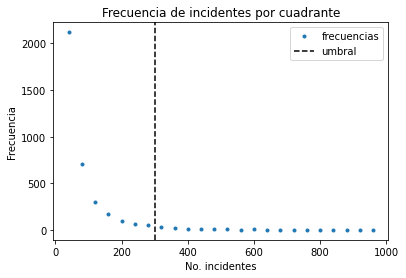

In [ ]:
segx = np.arange(H.min(),H.max(),40) 
y,x= np.histogram(H,bins=segx)
plt.plot(x[1:-1],y[1:],'.',label='frecuencias')
plt.title('Frecuencia de incidentes por cuadrante')
plt.xlabel('No. incidentes')
plt.ylabel('Frecuencia')
plt.axvline(umbralin,label='umbral',color='k', linestyle='--')
plt.legend()

In [ ]:
mayor_incidentes = pd.DataFrame({'longitud':xc,'latitud':yc})
mayor_incidentes = transform_data(mayor_incidentes)

Text(0.5, 1.0, 'Superposición entre avenidas principales y puntos de mayor incidencia')

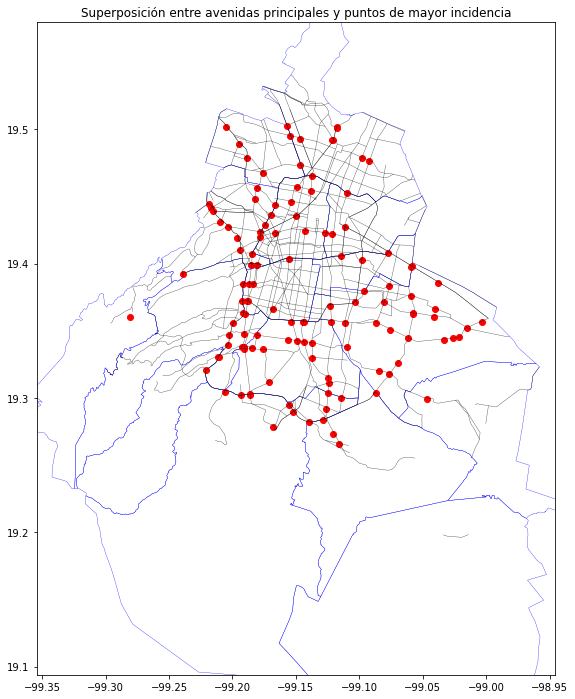

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(10, 12) ) 
#sns.histplot(data_code_A,x='longitud',y ='latitud',cmap='Blues',
#             ax=axes,binwidth=0.3/111.1,kde=True, cbar=False)

alcaldias.plot(ax=axes,markersize=0.5,facecolor="none", edgecolor='blue', lw=0.3 )

viasprincipales.plot(ax=axes,markersize=0.5,facecolor="none", edgecolor='black', lw=0.4,alpha=0.7 )

axes.scatter(xc,yc,color='red')
axes.set(xlim =(data_code_A['longitud'].min(),data_code_A['longitud'].max()),
         ylim =(data_code_A['latitud'].min(),data_code_A['latitud'].max()))

axes.set_title('Superposición entre avenidas principales y puntos de mayor incidencia')

### 6.2. Clasificación de los puntos de alta incidencia con K-Means



In [ ]:
inertia = []
for i in range (1,10):
  kmeans = cluster.KMeans(n_clusters = i, init = "k-means++", random_state=18)
  kmeans.fit((mayor_incidentes[['longitud','latitud']]))
  inertia.append(kmeans.inertia_)

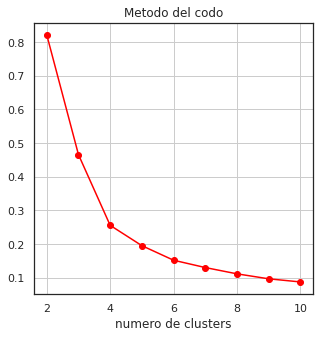

In [ ]:
# Vamos a graficar el método del codo
sns.set(style="white", rc={"figure.figsize":(5,5)})
plt.subplot(1,1,1)

plt.plot(range(2,len(inertia)+2), inertia, marker="o", color ="red")
plt.xlabel("numero de clusters")
plt.title("Metodo del codo")
plt.grid(True)

In [ ]:
k_means = KMeans(n_clusters=5, max_iter=10000)
clasificacion = k_means.fit(mayor_incidentes[['longitud','latitud']])
centers = k_means.cluster_centers_
pred = k_means.predict(mayor_incidentes[['longitud','latitud' ]])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Clasificación por distancia de los puntos de mayor incidencia')

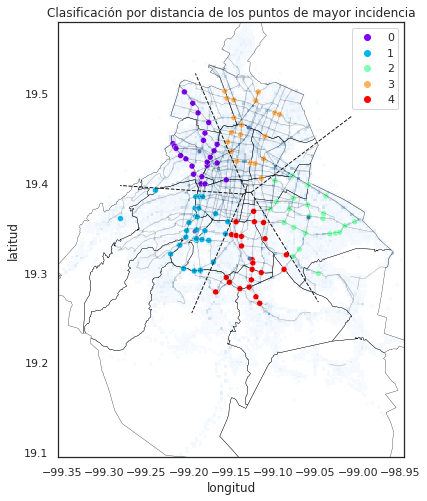

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(15, 8) ) 


sns.histplot(data_code_A,x='longitud',y ='latitud',cmap='Blues',
             ax=axes,binwidth=0.3/111.1)
alcaldias.plot(ax=axes,markersize=0.5,facecolor="none", edgecolor='black', lw=0.3 )

v = Voronoi(centers)
voronoi_plot_2d(v,ax=axes,show_vertices=False)
viasprincipales.plot(ax=axes,markersize=0.5,facecolor="none", edgecolor='black', lw=0.5,alpha=0.3 )

sns.scatterplot(mayor_incidentes['longitud'], mayor_incidentes['latitud'], ax=axes, hue=pred , palette='rainbow');

axes.set(xlim =(data_code_A['longitud'].min(),data_code_A['longitud'].max()),
         ylim =(data_code_A['latitud'].min(),data_code_A['latitud'].max()))

axes.set_title('Clasificación por distancia de los puntos de mayor incidencia')

Se realizó una clasificación a los datos de alta densidad de incidentes. Se considero una clasficiación en 5 de cuerdo al método del codo, regiones las cuales serven para estudiar a futuro la relación de las vías principales dentro de cada una de ellas. 

### 6.3 Avenidas principales de alto índice de incidentes 



Através de la cercania de los puntos de mayor indice de incidentes se puede obtener un filtrado de las vias con mayor probabilidad de íncidentes víales. 

Se calcula la distancia de cada punto de mayor incidencia a cada una de las curvas (vías principales) a trvés de una proyección. Después para cada una de las distancias se determina si la distancia entre el punto y la cruva es menor a una distancia dada, si lo es, entonces ese comulo incidentes coresponde a la vía principal.

In [ ]:
viasprincipales['indices_alto'] =  viasprincipales['geometry'].apply(lambda x: puntos_recta(x,mayor_incidentes,0.1/111.1))

In [ ]:
viasprincipales['no_alto'] = viasprincipales['indices_alto'].apply(len)

In [ ]:
viasprincipales['no_alto'].value_counts()

0     297
1      96
2      38
3      24
4       9
11      4
6       2
10      1
7       1
5       1
Name: no_alto, dtype: int64

In [ ]:
il = viasprincipales['no_alto']>=1

In [ ]:
order = viasprincipales[il].sort_values('no_alto',ascending=False)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


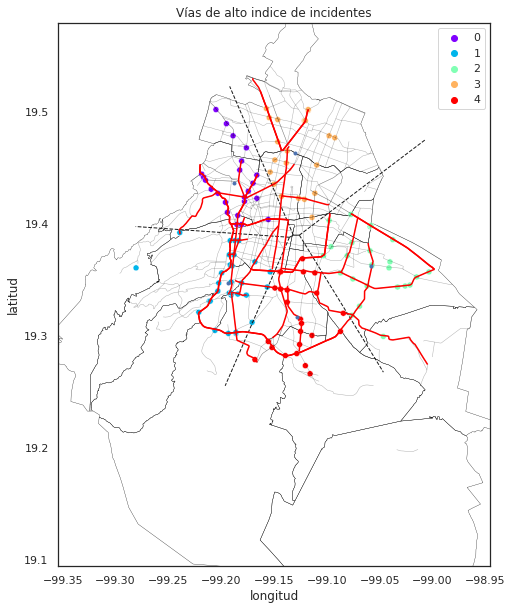

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(20, 10) ) 

#sns.histplot(data_code_A,x='longitud',y ='latitud',cmap='Blues',
#             ax=axes,binwidth=0.3/111.1)
alcaldias.plot(ax=axes,markersize=0.5,facecolor="none", edgecolor='black', lw=0.3 )

v = Voronoi(centers)
voronoi_plot_2d(v,ax=axes,show_vertices=False)
viasprincipales.plot(ax=axes,markersize=0.5,facecolor="none", edgecolor='black', lw=0.5,alpha=0.3 )

sns.scatterplot(mayor_incidentes['longitud'], mayor_incidentes['latitud'], ax=axes, hue=pred , palette='rainbow');

axes.set(xlim =(data_code_A['longitud'].min(),data_code_A['longitud'].max()),
         ylim =(data_code_A['latitud'].min(),data_code_A['latitud'].max()))

axes.set_title('Vías de alto indice de incidentes')
order[order['no_alto']>2].plot(ax=axes,color='red')

In [ ]:
vias_seleccion =  order[order['no_alto']>2]

In [ ]:
vias_seleccion.head(5)

,nombre,inicia,termina,tipo_via,vel_max,geometry,latitud,longitud,indices_alto,no_alto
302,Anillo Periferico Boulevard Adolfo Lopez Mateos,Eje 10 Sur Av. San Jeronimo,Paseo de la Reforma,Carriles laterales,40,"LINESTRING (-99.20264 19.42748, -99.20258 19.4...",19.379233,-99.195798,"[6, 7, 11, 12, 13, 14, 15, 17, 20, 21, 22]",11
166,Anillo Periferico Boulevard Adolfo Lopez Mateos,Eje 10 Sur Av. San Jeronimo,Paseo de la Reforma,Via de acceso controlado,80,"LINESTRING (-99.20264 19.42748, -99.20258 19.4...",19.379233,-99.195798,"[6, 7, 11, 12, 13, 14, 15, 17, 20, 21, 22]",11
315,Anillo Periferico Boulevard Adolfo Ruiz Cortinez,Av. Canal de Chalco,Eje 10 Sur Av. San Jeronimo,Via de acceso controlado,80,"LINESTRING (-99.21071 19.33131, -99.21095 19.3...",19.299943,-99.161742,"[2, 6, 7, 18, 31, 32, 54, 59, 69, 74, 100]",11
467,Anillo Periferico Boulevard Adolfo Ruiz Cortinez,Av. Canal de Chalco,Eje 10 Sur Av. San Jeronimo,Carriles laterales,40,"LINESTRING (-99.21071 19.33131, -99.21095 19.3...",19.299943,-99.161744,"[2, 6, 7, 18, 31, 32, 54, 59, 69, 74, 100]",11
401,Eje 8 Sur Calzada Ermita Iztapalapa,Calzada de Tlalpan,Calzada Ignacio Zaragoza,Eje Vial,50,"LINESTRING (-99.14327 19.36000, -99.14325 19.3...",19.351710,-99.069093,"[81, 91, 101, 107, 109, 119, 120, 121, 122, 123]",10


### 6.4. Estudio de los accidentes de cada vía principal



In [ ]:
via = vias_seleccion.iloc[0]['geometry']

In [ ]:
def get_alto_incident_via(via,data,alcaldias,scale,umbralin1=100):
  indes,num = incidentes_via(via,data ,alcaldias,scale)
  data_inc = data.loc[indes]
  H1,xc1,yc1 = mayor_densidad(data=data_inc,x='longitud',y='latitud',umbral=umbralin1,escala=scale)
  return H1,xc1,yc1,data_inc

In [ ]:
umbralin1 = 100
H1,xc1,yc1,data_inc = get_alto_incident_via(via,data_code_A,alcaldias,scale=0.1/111.1,umbralin1=100)

In [ ]:
seleccion = vias_seleccion.iloc[0:1]
seleccion

,nombre,inicia,termina,tipo_via,vel_max,geometry,latitud,longitud,indices_alto,no_alto
302,Anillo Periferico Boulevard Adolfo Lopez Mateos,Eje 10 Sur Av. San Jeronimo,Paseo de la Reforma,Carriles laterales,40,"LINESTRING (-99.20264 19.42748, -99.20258 19.4...",19.379233,-99.195798,"[6, 7, 11, 12, 13, 14, 15, 17, 20, 21, 22]",11


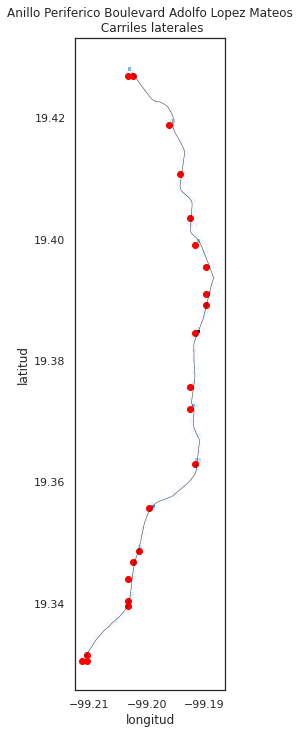

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(10, 12) ) 
sns.histplot(data_inc,x='longitud',y ='latitud',cmap='Blues',
             ax=axes,binwidth=0.05/111.1,kde=True, cbar=False)
seleccion.plot(ax=axes,edgecolor='black', lw=0.5,alpha=0.8 )

axes.scatter(xc1,yc1,color='red')
axes.set_title(f'{seleccion.iloc[0].nombre}\n {seleccion.iloc[0].tipo_via}');

In [ ]:
n=vias_seleccion

In [ ]:
datos = {}
for i in n.index:
  d = {}
  vial = n.loc[i]
  H1,xc1,yc1,data_inc = get_alto_incident_via(vial['geometry'],data_code_A,alcaldias,scale=0.1/111.1,umbralin1=100)
  d['data'] = data_inc 
  d['geometry'] = MultiPoint(list(zip(xc1,yc1)))
  datos[i] = d

In [ ]:
K = gpd.GeoDataFrame( pd.DataFrame(datos).transpose())

In [ ]:
a = np.array(K['geometry'].apply(np.array))

/usr/local/lib/python3.7/dist-packages/geopandas/geoseries.py:624: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


In [ ]:
P = np.concatenate(a)

In [ ]:
P  = transform_data( pd.DataFrame(P,columns=['longitud','latitud']))

In [126]:
def obt_values_count(K,lk):
  lk=2
  da = []
  for a in K.index:
    A = K.loc[a]['data']['incidente_c4'].value_counts()
    da.append((a,A.index[lk],A[lk]))
    E = pd.DataFrame(da,columns=['index','tipo','numero'] )
    E = E.set_index('index',drop=True)
  return E

In [128]:
E = obt_values_count(K,0)

In [138]:
n = vias_seleccion.loc[300]['nombre']

In [141]:
print(f'Para la avenida {n}, se registro como mayor tipo de accidentes {E.loc[300][0]}, con un numero de {E.loc[300][1]}')

Para la avenida Circuito Interior Rio Churubusco, se registro como mayor tipo de accidentes lesionado-atropellado, con un numero de 818


### 6.5. Mapa con capas interactivas de los resultados

In [ ]:
#Se crea un mapa para añadir información
centro = [19.432566, -99.133195]
Tmap =['Stamen Terrain','CartoDB Positron','Mapbox', ]
mapa_cdmx = folium.Map(location= centro, tiles=Tmap[1],
                       zoom_start=12,prefer_canvas=True,
                       max_zoom=18,min_zoom=9)

In [ ]:
add_data(alcaldias,mapa_cdmx,'Alcaldias','blue',grosor=1)
add_data(viasprincipales,mapa_cdmx,'Vías principales','black',grosor=0.7)

In [ ]:
#add_data(mayor_incidentes,mapa_cdmx,'Alto indice','blue')
#add_data(order ,mapa_cdmx,'Vías alto indice','red',grosor=1)

In [ ]:
circulos(mayor_incidentes,'longitud','latitud',mapa_cdmx,100,'Alta densidad','green')

In [ ]:
#mapdata(r,mapa_cdmx,tipo='heat')

In [ ]:
folium.map.LayerControl('topleft', collapsed= False).add_to(mapa_cdmx)

In [ ]:
mapa_cdmx

In [ ]:
mapa_cdmx.save('mapa2.html')

## 7. Técnicas de Machine Learning para el análisis predictivo



### 7.1 Predicciones con Random Forest

In [ ]:
Datos_predict=data_code_A[['dia_semana','mes','incidente_c4','delegacion_inicio']]
Datos_predict.head()

,dia_semana,mes,incidente_c4,delegacion_inicio
0,Sábado,1,accidente-choque sin lesionados,VENUSTIANO CARRANZA
1,Sábado,1,accidente-choque con lesionados,CUAJIMALPA
2,Domingo,1,accidente-choque sin lesionados,MIGUEL HIDALGO
3,Sábado,1,accidente-choque con lesionados,GUSTAVO A. MADERO
4,Domingo,1,accidente-choque con lesionados,VENUSTIANO CARRANZA


In [ ]:
#Separación de variables
Y=Datos_predict['incidente_c4']
X=Datos_predict[['dia_semana','mes','delegacion_inicio']]

In [ ]:
#Diccionarios de categorías
y_u={'accidente-choque sin lesionados':'1',
      'accidente-choque con lesionados':'2',
      'accidente-otros':'3',
      'lesionado-accidente automovilístico':'4',
      'lesionado-atropellado':'5',
      'accidente-volcadura':'6',
      'accidente-persona atrapada / desbarrancada':'7',
      'cadáver-accidente automovilístico':'8',
      'cadáver-atropellado':'9',
      'accidente-motociclista':'10',
      'accidente-choque con prensados':'11',
      'accidente-vehiculo atrapado':'12',
      'accidente-vehiculo desbarrancado':'13',
      'accidente-ciclista':'14',
      'accidente-monopatín':'15',
      'sismo-choque con lesionados':'16',
      'accidente-vehículo atrapado-varado':'17',
      'accidente-ferroviario':'18',
      'sismo-choque sin lesionados':'19',
      'sismo-persona atropellada':'20',
      'detención ciudadana-accidente automovilístico':'21',
      'detención ciudadana-atropellado':'22',
      'sismo-choque con prensados':'23',
      'mi ciudad-calle-incidente de tránsito':'24'}
X_d={'Sábado':'7', 'Domingo':'1', 'Lunes':'2', 'Martes':'3', 'Miércoles':'4', 'Jueves':'5', 'Viernes':'6'}
X_a={'VENUSTIANO CARRANZA':'1', 'CUAJIMALPA':'2', 'MIGUEL HIDALGO':'3', 'GUSTAVO A. MADERO':'4', 'COYOACAN':'5', 'TLAHUAC':'6', 'AZCAPOTZALCO':'7',
     'IZTACALCO':'8', 'MILPA ALTA':'9', 'BENITO JUAREZ':'10', 'CUAUHTEMOC':'11', 'IZTAPALAPA':'12', 'TLALPAN':'13', 'ALVARO OBREGON':'14',
     'XOCHIMILCO':'15', 'MAGDALENA CONTRERAS':'16'}

In [ ]:
#Cambio de variables categóricas numéricas en X Y
Y = Y.map(y_u)
X['dia_semana']=X['dia_semana'].map(X_d)
X['delegacion_inicio']=X['delegacion_inicio'].map(X_a)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
y=Y.astype(int)
X=np.array(X.astype(int))

Se hizo una primera predicción con todos los tipos de accidentes registrados

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.30,random_state=0)

In [ ]:
clf = RandomForestClassifier(n_estimators=800)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

In [ ]:
print('Accuracy: ',metrics.accuracy_score(y_test, y_pred))
plt.show()

Accuracy:  0.5669738505014563


Debido a que la presición del modelo era realmente baja, se optó por limitar los tipos de accidentes a los 5 más comúnes 

In [ ]:
#Primer recorte de registros
X_nueva=[]
y_nueva=[]
for i in range (0,len(y)):
  if y[i]==1 or y[i]==2 or y[i]==5 or y[i]==6 or y[i]==10 or y[i]==14:
    y_nueva.append(y[i])
    X_nueva.append(X[i])

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_nueva,y_nueva,test_size=0.30,random_state=0)

In [ ]:
clf = RandomForestClassifier(n_estimators=800)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

In [ ]:
print('Accuracy: ',metrics.accuracy_score(y_test, y_pred))
plt.show()

Accuracy:  0.5774544890474554


Aún con el cambio, la presición del modelo sigue siendo muy baja, por lo que se tomaron solo los dos tipos de aacidentes con más registros

In [ ]:
#Segundo recorte de registros
y_nueva2=[]
X_nueva2=[]
for i in range (0,len(y)):
  if y[i]==1 or y[i]==2:
    y_nueva2.append(y[i])
    X_nueva2.append(X[i])

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_nueva2,y_nueva2,test_size=0.30,random_state=0)

In [ ]:
clf = RandomForestClassifier(n_estimators=800)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

In [ ]:
print('Accuracy: ',metrics.accuracy_score(y_test, y_pred))
plt.show()

Accuracy:  0.7197585826104471


In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_nueva2,y_nueva2,test_size=0.25,random_state=0)

In [ ]:
clf = RandomForestClassifier(n_estimators=800)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

In [ ]:
print('Accuracy: ',metrics.accuracy_score(y_test, y_pred))
plt.show()

Accuracy:  0.7202340273031854


### 7.2. Predicciones sobre las Series de Tiempo

In [ ]:
serie_accidentes = pd.DataFrame(data_code_A.groupby(['fecha_creacion']).size())

In [ ]:
serie_accidentes = serie_accidentes.reset_index()

In [ ]:
dias = pd.Series(serie_accidentes.index)
incidentes = pd.Series(serie_accidentes[0])

In [ ]:
lr = LinearRegression()
lr.fit(dias.to_frame(),incidentes)
y_predict = lr.predict(dias.to_frame())

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(18, 5) ) 
sns.lineplot(dias,incidentes,ax=axes)
sns.lineplot(dias, y_predict);

In [ ]:
#Graficación de la serie por año
serie_accidentes2 = pd.DataFrame(data_code_A.groupby(['fecha_creacion']).size())
serie_accidentes.plot()
pyplot.show()

Error cuadrático medio(RMSE) de la prueba: 25.712


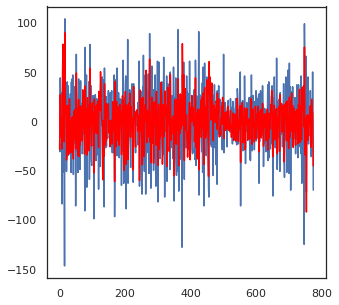

In [ ]:
# Aplicación del modelo de Autoregresión lineal (AR)
# Crear una transformación de diferencia del conjunto de datos
def difference(dataset):
	diff = list()
	for i in range(1, len(dataset)):
		value = dataset[i] - dataset[i - 1]
		diff.append(value)
	return np.array(diff)
 
# Hacer una predicción con coeficientes de regresión y observaciones de periodos anteriores
def predict(coef, history):
	yhat = coef[0]
	for i in range(1, len(coef)):
		yhat += coef[i] * history[-i]
	return yhat
 
# División del dataset
X = difference(serie_accidentes2.values)
size = int(len(X) * 0.70)
train, test = X[0:size], X[size:]

# Entrenamiento de la Autoregresión
window = 6
model = AutoReg(train, lags=6)
model_fit = model.fit()
coef = model_fit.params

# Ir hacia adelante en los pasos del tiempo en la prueba
history = [train[i] for i in range(len(train))]
predictions = list()
for t in range(len(test)):
	yhat = predict(coef, history)
	obs = test[t]
	predictions.append(yhat)
	history.append(obs)
rmse = sqrt(mean_squared_error(test, predictions))
print('Error cuadrático medio(RMSE) de la prueba: %.3f' % rmse)

# Graficación de los datos observados contra la predicción
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

In [ ]:
#Evaluar un modelo ARIMA utilizando una validación de avance (ARIMA = Modelo autorregresivo integrado de media móvil)
incidentes2 = pd.Series(serie_accidentes[0])
incidentes2.head(10)

# Dividir los conjuntos de entrenamiento y pruebas
X = incidentes2.values
size = int(len(X) * 0.70)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

# Validación de avance
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))

# Evaluación de predicciones
rmse = sqrt(mean_squared_error(test, predictions))
print('Error cuadrático medio (RMSE) de la prueba: %.3f' % rmse)

# Graficación de las predicciones contra los resultados reales
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

## 8. Planes a futuro

El estudio continuo y la relación con otros tipos de variables es esencial para la mejora del proyecto, esto es, para realizar análisis más complejos con el uso de diferentes tipos de datasets. Además, sería posible realizar análisis en tiempo real, lo que presupondría la adquisición de datos en tiempo real. El método que hemos trabajado es transferible y adaptable a fenómenos similares y se podrían dar a conocer sus beneficios a plataformas de movilidad inteligente. Incluso los resultados que el método heurístico ha arrojado podrían utilizarse para campañas de educación, seguridad vial y sensibilización, como aquella denominada “Nos vemos en la esquina”, lanzada hace un par de años.
De igual forma, la importancia y complejidad del problema y la continua y cotidiana recopilación de datos, sustentan la existencia de una línea de investigación permanente relativa a los incidentes viales en la CDMX.

## 9. Conclusiones

A lo largo del proyecto se programaron suficientes algoritmos para la obtención y visualización de información de diversa índole acerca de la problemática identificada. Se identificaron zonas de alto riesgo para accidentes y además se determinaron las vías principales de la CDMX con un número alto de incidentes viales. Para cada vía con alta densidad de incidentes se obtuvo el conjunto de datos y se determinó el tipo de accidentes que se presentan. Por último, el desarrollo aplicado y continuo de un proyecto de esta naturaleza nos permitió integrar los conocimientos sobre Data Science, incluyendo las técnicas fundamentales de Machine Learning para estudiar con amplitud una problemática particular relativa a los incidentes viales en la CDMX.
